# **EXTRACCION, TRANSFORMACION Y MODELO DE ML DE LA API DE OPEN METEO PARA MONTERREY EN EL ESTADO DE NUEVO LEON**

Instalamos la libreria de la API

In [48]:
pip install openmeteo-requests

In [29]:
import openmeteo_requests
import pandas as pd

Empezamos definiendo los parametros (ubicacion, zona horaria, rango de fechas y recursos a pedir) que daremos a la API para la extraccion de nuestros datos:

In [41]:
openmeteo = openmeteo_requests.Client()
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 25.67507,
	"longitude": -100.31847,
	"start_date": "2020-01-01",
	"end_date": "2024-12-31",
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

In [44]:
# Procesamos la respuesta de la API y extraemos cada variable para volverla un arreglo
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_rain_sum = daily.Variables(3).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(5).ValuesAsNumpy()

# Creamos un diccionario con los datos
daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["rain_sum"] = daily_rain_sum
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)

Comprobamos el inicio de los datos para revisar que sean de Enero de 2020

In [46]:
daily_dataframe.head()

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,wind_speed_10m_max,shortwave_radiation_sum
0,2020-01-01 06:00:00+00:00,16.940500,9.690500,13.163418,18.5,12.240000,4.960000
1,2020-01-02 06:00:00+00:00,18.640499,11.140500,14.478001,4.4,12.387348,6.050000
2,2020-01-03 06:00:00+00:00,19.090500,9.990500,15.886334,0.0,29.215502,15.440000
3,2020-01-04 06:00:00+00:00,18.190500,7.590500,12.559253,0.0,10.002560,16.549999
4,2020-01-05 06:00:00+00:00,21.140499,10.040501,14.955086,0.0,7.280550,16.549999


Comprobamos el final de los datos para revisar que sean de Diciembre de 2024

In [47]:
daily_dataframe.tail()

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,rain_sum,wind_speed_10m_max,shortwave_radiation_sum
1822,2024-12-27 06:00:00+00:00,27.240499,11.940500,19.003000,0.0,7.814985,15.260000
1823,2024-12-28 06:00:00+00:00,31.490499,11.940500,20.577999,0.0,18.275984,16.080000
1824,2024-12-29 06:00:00+00:00,26.890499,9.640500,18.017584,0.0,7.731622,16.190001
1825,2024-12-30 06:00:00+00:00,31.090500,10.290501,19.842585,0.0,8.909545,16.580000
1826,2024-12-31 06:00:00+00:00,29.240499,12.490500,20.144667,0.0,10.661107,16.360001


Este paso lo realice en AWS con un crawler y un ETL job para anadir un campo ID junto con un CHANGE SCHEMA para cambiar el tipo de dato de DATE a date junto con un cambio en los nombres.

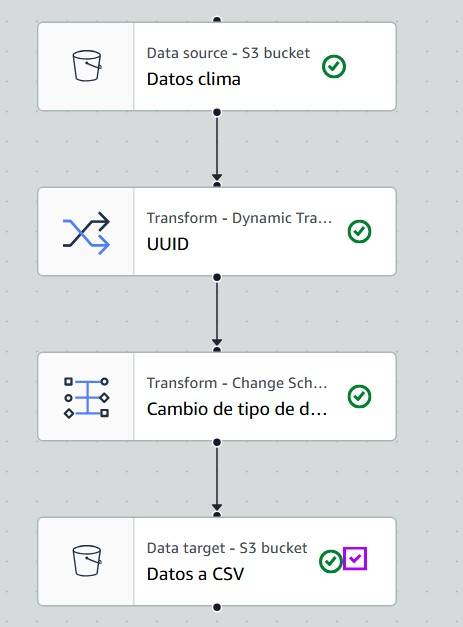

In [52]:
url = "https://raw.githubusercontent.com/JesusVargasF/proyecto_clima_mty/refs/heads/main/datos_clima_mty.csv"
df_clima = pd.read_csv(url)
df_clima.head()

,date,temperature_max,temperature_min,temperature_mean,rain_sum,wind_speed,shortwave_radiation,id
0,2020-01-01,16.9405,9.690500,13.163418,18.5,12.240000,4.96,8aec03dd-c8cf-4cc9-994c-bc9a2c0fc923
1,2020-01-02,18.6405,11.140500,14.478001,4.4,12.387348,6.05,6c38cd5d-44c2-4ff1-9449-06b056bced72
2,2020-01-03,19.0905,9.990500,15.886334,0.0,29.215502,15.44,5cda1a13-7008-4d99-b658-b756aaa8c21c
3,2020-01-04,18.1905,7.590500,12.559253,0.0,10.002560,16.55,f7d399fe-1d96-46d6-9c98-ed945aadb282
4,2020-01-05,21.1405,10.040501,14.955086,0.0,7.280550,16.55,853aa109-ea02-4df4-bd6d-b56578bff110


In [53]:
df_clima.tail()

,date,temperature_max,temperature_min,temperature_mean,rain_sum,wind_speed,shortwave_radiation,id
1822,2024-12-27,27.2405,11.940500,19.003000,0.0,7.814985,15.26,084a2695-7300-487a-8d68-56161ff1f80f
1823,2024-12-28,31.4905,11.940500,20.578000,0.0,18.275984,16.08,10f3d34d-3c99-4f6e-88cb-49867e6fd2bb
1824,2024-12-29,26.8905,9.640500,18.017584,0.0,7.731622,16.19,8af31bfe-afbb-413a-8015-f407dd8c0fe6
1825,2024-12-30,31.0905,10.290501,19.842585,0.0,8.909545,16.58,b304ce59-3739-486d-8b42-94ab2afee4e1
1826,2024-12-31,29.2405,12.490500,20.144667,0.0,10.661107,16.36,fb690b68-eccc-4a5a-8680-d0c83a98511b


In [76]:
df_clima.rename(columns={
    "date": "Fecha",
    "temperature_max": "Temperatura_maxima",
    "temperature_min": "temperatura_minima",
    "temperature_mean": "temperatura_promedio",
    "rain_sum": "luvia_total",
    "wind_speed": "velocidad_viento",
    "shortwave_radiation": "radiacion_solar"
},inplace=True)

df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha                 1827 non-null   object 
 1   Temperatura_maxima    1827 non-null   float64
 2   Temperatura_minima    1827 non-null   float64
 3   Temperatura_promedio  1827 non-null   float64
 4   Luvia_total           1827 non-null   float64
 5   Velocidad_viento      1827 non-null   float64
 6   radiacion_solar       1827 non-null   float64
 7   id                    1827 non-null   object 
dtypes: float64(6), object(2)
memory usage: 114.3+ KB


Revisamos datos duplicados

In [70]:
# Numero de duplicados
num_duplicados = df_clima.duplicated().sum()
print(f"Numero de duplicados: {num_duplicados}")

Numero de duplicados: 0


Revisamos datos null

In [80]:
# Numero de datos Null
num_null = df_clima.isnull().sum()
print(f"Numero de datos Null: \n{num_null}")

Numero de datos Null: 
fecha                   0
temperatura_maxima      0
temperatura_minima      0
temperatura_promedio    0
lluvia_total            0
velocidad_viento        0
radiacion_solar         0
id                      0
dtype: int64


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
numerical_columns = ["temperatura_maxima", "temperatura_minima", "temperatura_promedio", "lluvia_total", "velocidad_viento", "radiacion_solar"]

In [86]:
# Revisar estadisticas basicas del dataframe
df_clima.describe()

,temperatura_maxima,temperatura_minima,temperatura_promedio,lluvia_total,velocidad_viento,radiacion_solar
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,28.198738,17.202186,22.315903,1.708812,14.673740,19.246754
std,6.769186,5.764061,6.027130,6.304632,4.536718,6.038004
min,5.390500,-6.709500,-0.172000,0.000000,4.553680,2.550000
25%,23.890500,13.440500,18.406126,0.000000,11.503113,15.600000
50%,29.140500,18.490500,23.296753,0.000000,14.494192,19.790000
75%,33.190502,21.940500,26.864460,0.700000,17.525751,24.160000
max,44.590500,27.090500,34.928000,121.799995,30.551254,29.750000


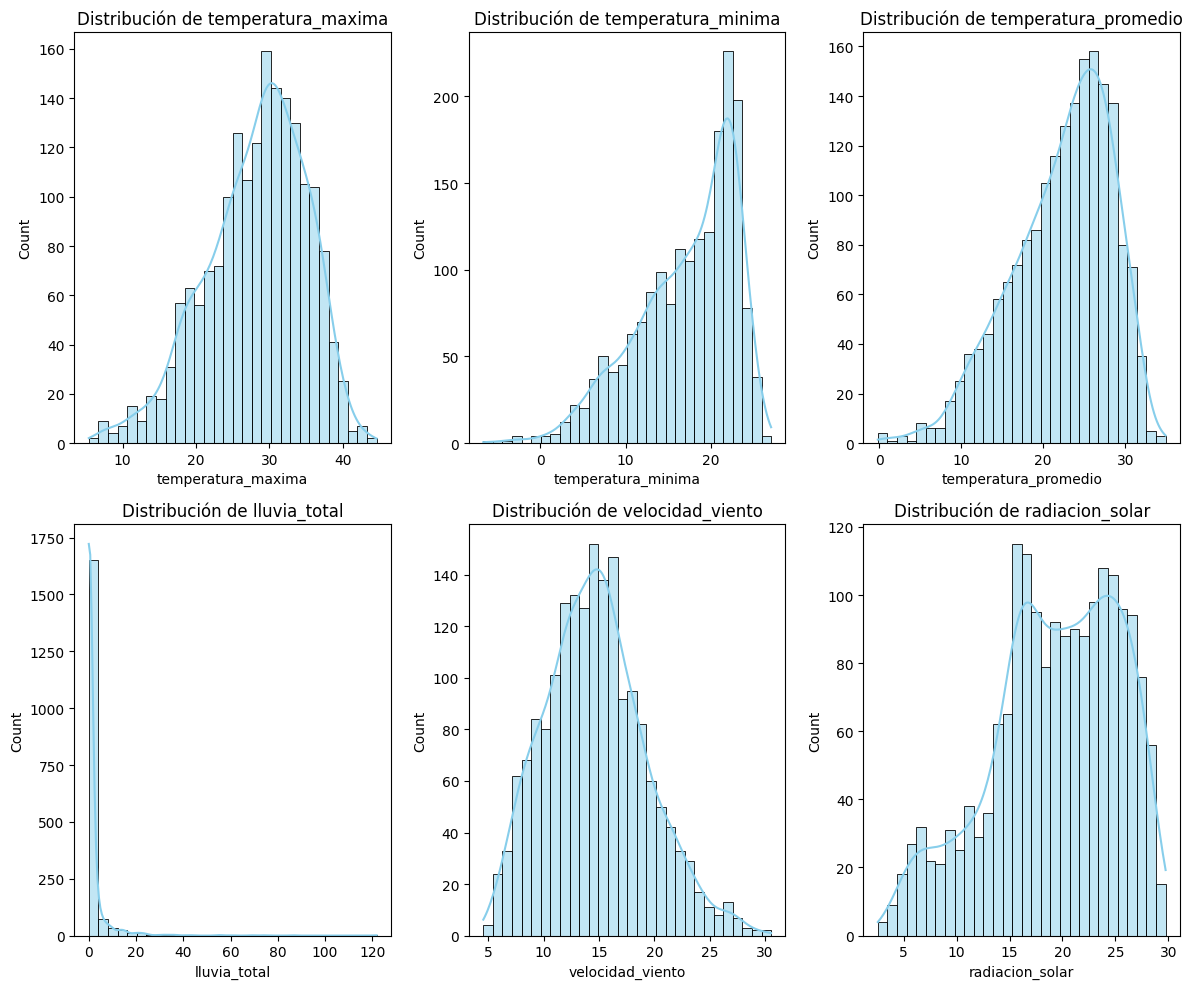

In [87]:
# Graficamos cada una de las variables
plt.figure(figsize=(12, 10))

for i, col in enumerate(numerical_columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_clima[col].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f'Distribución de {col}')

plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

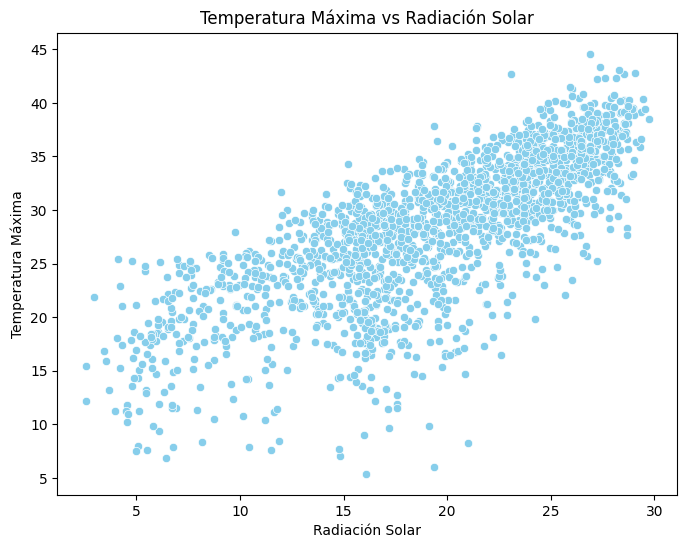

In [105]:
# Temperatura maxima vs radiacion solar
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clima, y='temperatura_maxima', x='radiacion_solar', color='skyblue')
plt.title('Temperatura Máxima vs Radiación Solar')
plt.ylabel('Temperatura Máxima')
plt.xlabel('Radiación Solar')
plt

Text(0.5, 1.0, 'Temperatura Promedio vs Radiación Solar')

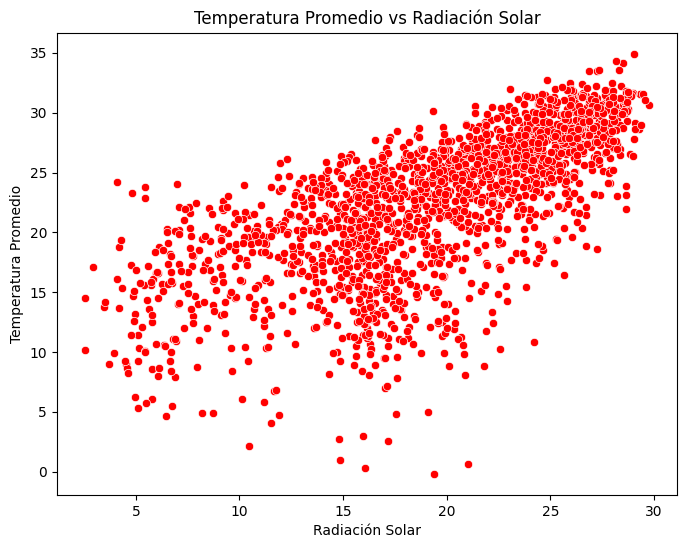

In [110]:
# Temperatura promedio vs radiacion solar
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clima, y='temperatura_promedio', x='radiacion_solar', color='red')
plt.ylabel('Temperatura Promedio')
plt.xlabel('Radiación Solar')
plt.title('Temperatura Promedio vs Radiación Solar')

MATRIZ DE CORRELACION

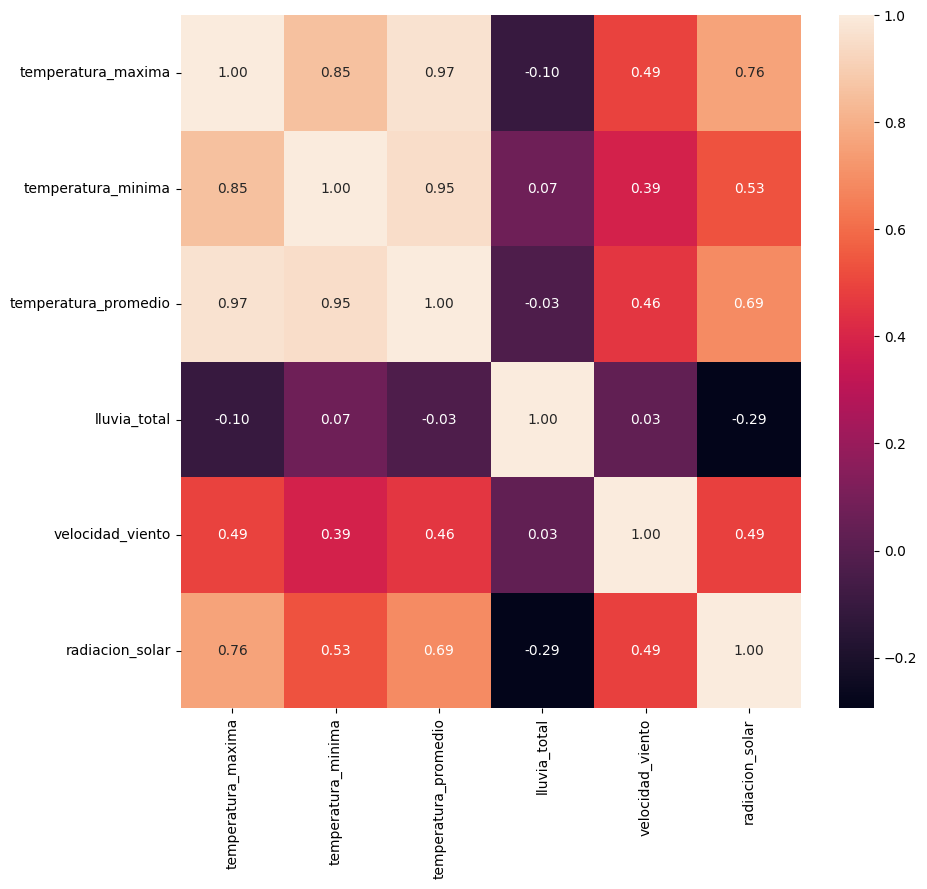

In [111]:
# Matriz de correlacion
df_clima_numerico = df_clima.select_dtypes(include=['float64', 'int64']).drop(columns=["year","month","day","es_dia"],errors="ignore")
plt.figure(figsize=(10, 9))
sns.heatmap(df_clima_numerico.corr(), annot=True, fmt='.2f')
plt.show()

## Normalizacion de los datos con sklearn

In [112]:
from sklearn.preprocessing import MinMaxScaler

In [113]:
# Copiar el Datframe para escalado
df_clima_escalado = df_clima.copy()

In [114]:
numerical_columns = ["temperatura_maxima", "temperatura_minima", "temperatura_promedio", "lluvia_total", "velocidad_viento", "radiacion_solar"]

## Escalado con MinMaxScaler

In [115]:
# Aplicar el escalado a las columnas numericas
scaler = MinMaxScaler() # Inicializar el scaler (Escalado de valores por defecto entre 0 y 1)
df_clima_escalado[numerical_columns] = scaler.fit_transform(df_clima_escalado[numerical_columns]) # Escogemos las columnas a escalar dentro del fit_transform

# Mostrar vista previa del DF
df_clima_escalado.describe()

,temperatura_maxima,temperatura_minima,temperatura_promedio,lluvia_total,velocidad_viento,radiacion_solar
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,0.581843,0.707446,0.640681,0.014030,0.389269,0.613851
std,0.172683,0.170534,0.171713,0.051762,0.174505,0.221985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.471939,0.596154,0.529291,0.000000,0.267311,0.479779
50%,0.605867,0.745562,0.668625,0.000000,0.382363,0.633824
75%,0.709184,0.847633,0.770270,0.005747,0.498972,0.794485
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Seleccion de variables

In [117]:
# Definir las variables predictoras y la varible objetivo (La que vamos a predecir)
predictoras = ["temperatura_minima", "temperatura_promedio", "lluvia_total", "velocidad_viento", "radiacion_solar"]
variable_objetivo = "temperatura_maxima"

# Variables predictoras (X) y variables objetivo (y)
x = df_clima[predictoras]
y = df_clima[variable_objetivo]

## Mejores K Variables

In [124]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [122]:
# Definimimos el numero de caracteristicas que queremos retener
k = 3 # Seleccionamos las 3 mejores caracteristicas

# Craer el selector de caracteristicas usando f_regression
selector = SelectKBest(score_func=f_regression, k=k)

# Ajustar el selector a los datos
x_new = selector.fit_transform(x, y)

#Obtener los nombres de las caractertisticas seleccionadas
selected_features = x.columns[selector.get_support()]

# Imprimir las caracteristicas seleccionadas
print("Caracteristicas seleccionadas con SelectKBest y F regression:", selected_features.tolist())

Caracteristicas seleccionadas con SelectKBest: ['temperatura_minima', 'temperatura_promedio', 'radiacion_solar']


## MUTUAL INFO REGRESSION

In [125]:
# Definir el número de características a seleccionar
k = 3  # Seleccionamos las 3 mejores características

# Inicializar el selector con mutual_info_regression como función de puntuación
selector = SelectKBest(score_func=mutual_info_regression, k=k)

# Ajustar el selector a los datos y transformar X para obtener únicamente las k mejores características
X_new = selector.fit_transform(x, y)

# Obtener los nombres de las características seleccionadas
selected_features = x.columns[selector.get_support()]

print("Características seleccionadas por SelectKBest con mutual_info_regression:")
print(selected_features.tolist())

Características seleccionadas por SelectKBest con mutual_info_regression:
['temperatura_minima', 'temperatura_promedio', 'radiacion_solar']


In [127]:
# Copiamos el dataframe escalado
df_clima_seleccionadas = df_clima_escalado.copy()

# Se eliminan las columnas que no son relevantes para la prediccion
df_clima_seleccionadas = df_clima[["temperatura_minima", "temperatura_promedio", "radiacion_solar"]]

df_clima_seleccionadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperatura_minima    1827 non-null   float64
 1   temperatura_promedio  1827 non-null   float64
 2   radiacion_solar       1827 non-null   float64
dtypes: float64(3)
memory usage: 42.9 KB


## Creamos el primer modelo

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Probaremos predecir temperatura maxima en base a la radicion solar y las temperatura promedio y minima

In [129]:
# Lista de columnas numéricas
numerical_columns = ["temperatura_minima", "temperatura_promedio", "radiacion_solar"]

df_clima_scaled = df_clima.copy()

# MinMaxScaler hace un escalado de valores por defecto entre 0 y 1.
scaler = MinMaxScaler()
df_clima_scaled[numerical_columns] = scaler.fit_transform(df_clima_scaled[numerical_columns])

# Mostrar una vista previa del DataFrame escalado
print("Primeras filas del DataFrame escalado:")
df_clima_scaled.describe()

Primeras filas del DataFrame escalado:


,temperatura_maxima,temperatura_minima,temperatura_promedio,lluvia_total,velocidad_viento,radiacion_solar
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,28.198738,0.707446,0.640681,1.708812,14.673740,0.613851
std,6.769186,0.170534,0.171713,6.304632,4.536718,0.221985
min,5.390500,0.000000,0.000000,0.000000,4.553680,0.000000
25%,23.890500,0.596154,0.529291,0.000000,11.503113,0.479779
50%,29.140500,0.745562,0.668625,0.000000,14.494192,0.633824
75%,33.190502,0.847633,0.770270,0.700000,17.525751,0.794485
max,44.590500,1.000000,1.000000,121.799995,30.551254,1.000000


In [130]:
df_clima_scaled['temperatura_max_class'] = df_clima_scaled['temperatura_maxima'].round().astype(int)
df_clima_scaled.head()

,fecha,temperatura_maxima,temperatura_minima,temperatura_promedio,lluvia_total,velocidad_viento,radiacion_solar,id,temperatura_max_class
0,2020-01-01,16.9405,0.485207,0.379926,18.5,12.240000,0.088603,8aec03dd-c8cf-4cc9-994c-bc9a2c0fc923,17
1,2020-01-02,18.6405,0.528107,0.417379,4.4,12.387348,0.128676,6c38cd5d-44c2-4ff1-9449-06b056bced72,19
2,2020-01-03,19.0905,0.494083,0.457502,0.0,29.215502,0.473897,5cda1a13-7008-4d99-b658-b756aaa8c21c,19
3,2020-01-04,18.1905,0.423077,0.362714,0.0,10.002560,0.514706,f7d399fe-1d96-46d6-9c98-ed945aadb282,18
4,2020-01-05,21.1405,0.495562,0.430971,0.0,7.280550,0.514706,853aa109-ea02-4df4-bd6d-b56578bff110,21


In [131]:
# Definir las variables preductoras y la objetivo
predictoras = ["temperatura_minima", "temperatura_promedio", "radiacion_solar"]
objetivo = "temperatura_max_class"

# Variables predictoras en X y la objetivo en Y
x = df_clima_scaled[predictoras]
y = df_clima_scaled[objetivo]

# Dividir los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

 # Entrenar el modelo RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [133]:
# Realizar predicciones y evaluar el modelo random forest
y_pred = rf_model.predict(x_test)

In [134]:
# Cálculo de métricas para RandomForest
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=True)
recall = recall_score(y_test, y_pred, average='macro', zero_division=True)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=True)

print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1-score (macro):", f1)

Accuracy: 0.31693989071038253
Precision (macro): 0.36384311757118776
Recall (macro): 0.2997367553233921
F1-score (macro): 0.2479349306996814


Tiene muy bajo score en nuestras metricas entonces nuestro modelo no es fiable

## Probamos obtener la radiacion solar en base a la temperatura

In [135]:
# Lista de columnas numéricas
numerical_columns = ["temperatura_minima", "temperatura_promedio", "temperatura_maxima"]

df_clima_scaled = df_clima.copy()

# MinMaxScaler hace un escalado de valores por defecto entre 0 y 1.
scaler = MinMaxScaler()
df_clima_scaled[numerical_columns] = scaler.fit_transform(df_clima_scaled[numerical_columns])

# Mostrar una vista previa del DataFrame escalado
print("Primeras filas del DataFrame escalado:")
df_clima_scaled.describe()

Primeras filas del DataFrame escalado:


,temperatura_maxima,temperatura_minima,temperatura_promedio,lluvia_total,velocidad_viento,radiacion_solar
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,0.581843,0.707446,0.640681,1.708812,14.673740,19.246754
std,0.172683,0.170534,0.171713,6.304632,4.536718,6.038004
min,0.000000,0.000000,0.000000,0.000000,4.553680,2.550000
25%,0.471939,0.596154,0.529291,0.000000,11.503113,15.600000
50%,0.605867,0.745562,0.668625,0.000000,14.494192,19.790000
75%,0.709184,0.847633,0.770270,0.700000,17.525751,24.160000
max,1.000000,1.000000,1.000000,121.799995,30.551254,29.750000


In [136]:
threshold = df_clima_scaled['radiacion_solar'].median()
df_clima_scaled['alta_radiacion'] = (df_clima_scaled['radiacion_solar'] > threshold).astype(int)

In [137]:
df_clima_scaled.describe()

,temperatura_maxima,temperatura_minima,temperatura_promedio,lluvia_total,velocidad_viento,radiacion_solar,alta_radiacion
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,0.581843,0.707446,0.640681,1.708812,14.673740,19.246754,0.499726
std,0.172683,0.170534,0.171713,6.304632,4.536718,6.038004,0.500137
min,0.000000,0.000000,0.000000,0.000000,4.553680,2.550000,0.000000
25%,0.471939,0.596154,0.529291,0.000000,11.503113,15.600000,0.000000
50%,0.605867,0.745562,0.668625,0.000000,14.494192,19.790000,0.000000
75%,0.709184,0.847633,0.770270,0.700000,17.525751,24.160000,1.000000
max,1.000000,1.000000,1.000000,121.799995,30.551254,29.750000,1.000000


In [138]:
# Definir las variables preductoras y la objetivo
predictoras = ["temperatura_minima", "temperatura_promedio", "temperatura_maxima"]
objetivo = "alta_radiacion"

# Variables predictoras en X y la objetivo en Y
x = df_clima_scaled[predictoras]
y = df_clima_scaled[objetivo]

# Dividir los datos en conjuntos de entrenamiento y prueba (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

 # Entrenar el modelo RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [139]:
# Realizar predicciones y evaluar el modelo random forest
y_pred = rf_model.predict(x_test)

In [140]:
# Cálculo de métricas para RandomForest
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=True)
recall = recall_score(y_test, y_pred, average='macro', zero_division=True)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=True)

print("Accuracy:", accuracy)
print("Precision (macro):", precision)
print("Recall (macro):", recall)
print("F1-score (macro):", f1)

Accuracy: 0.8333333333333334
Precision (macro): 0.8337016574585636
Recall (macro): 0.8348717333972668
F1-score (macro): 0.8332324929971989


## Creamos la matriz de confusion

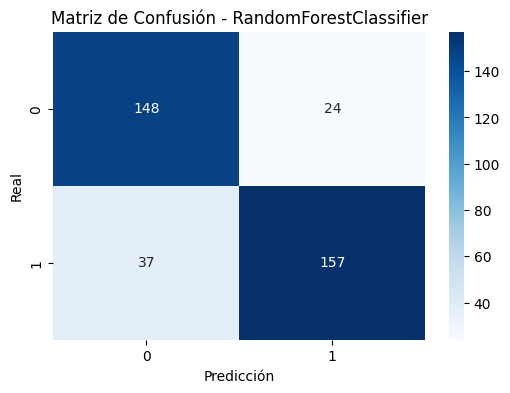

In [141]:
cm_rf = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - RandomForestClassifier")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()